In [58]:
from pandas import DataFrame, read_csv, set_option
from matplotlib.pyplot import figure, show, subplots, savefig
from ds_charts import dummify, plot_line, multiple_line_chart
from  mlxtend.frequent_patterns import apriori, association_rules
set_option('display.max_columns', None)

sample = 0.01

file_tag = 'set2'
filename = 'lab03_knn_and_scaling/ew_data/set2'
target = 'ALARM'

dataOriginal: DataFrame = read_csv(f'ew_data/{file_tag}_mv_dummified.csv')
dataOriginal = dataOriginal.sample(frac=sample, replace=True, random_state=1)

## Without numerical data

In [59]:
data_treatment = 'wo_numeric'
data = dataOriginal.drop([target, 'GbCity', 'GbProv','Field_1', 'CO_Mean','CO_Min', 'CO_Max', 'CO_Std', 'NO2_Mean', 'NO2_Min', 'NO2_Max', 'NO2_Std', 'O3_Mean', 'O3_Min', 'O3_Max','O3_Std', 'PM2.5_Mean', 'PM2.5_Min','PM2.5_Max','PM2.5_Std','PM10_Mean','PM10_Min','PM10_Max','PM10_Std','SO2_Mean','SO2_Min','SO2_Max','SO2_Std','hour','day','year'], axis=1)
data.fillna(False)
data = data.astype(int)
data

,City_EN_Abacangzuqiangzu,City_EN_Akesudiqu,City_EN_Alashan,City_EN_Aletaidiqu,City_EN_Alidiqu,City_EN_Ankang,City_EN_Anqing,City_EN_Anshan,City_EN_Anshun,City_EN_Anyang,City_EN_Baicheng,City_EN_Baisediqu,City_EN_Baishan,City_EN_Baiyin,City_EN_Baoding,City_EN_Baoji,City_EN_Baoshandiqu,City_EN_Baotou,City_EN_Bayannaoer,City_EN_Bazhong,City_EN_Beihai,City_EN_Beijing,City_EN_Bengbu,City_EN_Benxi,City_EN_Bijiediqu,City_EN_Binzhou,City_EN_Boertalamenggu,City_EN_Bozhou,City_EN_Cangzhou,City_EN_Changchun,City_EN_Changde,City_EN_Changdudiqu,City_EN_Changjihuizu,City_EN_Changsha,City_EN_Changzhi,City_EN_Changzhou,City_EN_Chaoyang,City_EN_Chaozhou,City_EN_Chengde,City_EN_Chengdu,City_EN_Chenzhou,City_EN_Chifeng,City_EN_Chizhou,City_EN_Chongqing,City_EN_Chuxiongyizu,City_EN_Chuzhou,City_EN_Dalian,City_EN_Dalibaizu,City_EN_Dandong,City_EN_Daqing,City_EN_Datong,City_EN_Daxinganlingdiqu,City_EN_Dazhou,City_EN_Dehongdaizujingpozu,City_EN_Deyang,City_EN_Dezhou,City_EN_Dingxidiqu,City_EN_Diqingcangzu,City_EN_Dongguan,City_EN_Dongying,City_EN_Enshitujiazumiaozu,City_EN_Ezhou,City_EN_Fangchenggang,City_EN_Foshan,City_EN_Fushun,City_EN_Fuxin,City_EN_Fuyang,City_EN_Fuzhou,City_EN_Gannancangzu,City_EN_Ganzhou,City_EN_Ganzicangzu,City_EN_Guangan,City_EN_Guangyuan,City_EN_Guangzhou,City_EN_Guigang,City_EN_Guilin,City_EN_Guiyang,City_EN_Guoluocangzu,City_EN_Guyuandiqu,City_EN_Haerbin,City_EN_Haibeicangzu,City_EN_Haidongdiqu,City_EN_Haikou,City_EN_Hainancangzu,City_EN_Haiximengguzucangzu,City_EN_Hamidiqu,City_EN_Handan,City_EN_Hangzhou,City_EN_Hanzhong,City_EN_Hebi,City_EN_Hechidiqu,City_EN_Hefei,City_EN_Hegang,City_EN_Heihe,City_EN_Hengshui,City_EN_Hengyang,City_EN_Hetiandiqu,City_EN_Heyuan,City_EN_Heze,City_EN_Hezhoudiqu,City_EN_Honghehanizuyizu,City_EN_Huaibei,City_EN_Huaihua,City_EN_Huainan,City_EN_Huaiyin,City_EN_Huanggang,City_EN_Huangnancangzu,City_EN_Huangshan,City_EN_Huangshi,City_EN_Huhehaote,City_EN_Huizhou,City_EN_Huludao,City_EN_Hulunbeier,City_EN_Huzhou,City_EN_Jiamusi,City_EN_Jian,City_EN_Jiangmen,City_EN_Jiaozuo,City_EN_Jiaxing,City_EN_Jiayuguan,City_EN_Jieyang,City_EN_Jilin,City_EN_Jinan,City_EN_Jinchang,City_EN_Jincheng,City_EN_Jingdezhen,City_EN_Jingmen,City_EN_Jingzhou,City_EN_Jinhua,City_EN_Jining,City_EN_Jinzhong,City_EN_Jinzhou,City_EN_Jiujiang,City_EN_Jiuquandiqu,City_EN_Jixi,City_EN_Kaifeng,City_EN_Kashendiqu,City_EN_Kelamayi,City_EN_Kezilesukeerkezi,City_EN_Kunming,City_EN_Langfang,City_EN_Lanzhou,City_EN_Lasa,City_EN_Leshan,City_EN_Liangshanyizu,City_EN_Lianyungang,City_EN_Liaocheng,City_EN_Liaoyang,City_EN_Liaoyuan,City_EN_Lijiangdiqu,City_EN_Lincangdiqu,City_EN_Linfen,City_EN_Linxiahuizu,City_EN_Linyi,City_EN_Linzhidiqu,City_EN_Lishui,City_EN_Liuan,City_EN_Liupanshui,City_EN_Liuzhou,City_EN_Longnandiqu,City_EN_Longyan,City_EN_Loudi,City_EN_Luohe,City_EN_Luoyang,City_EN_Luzhou,City_EN_Lvliangdiqu,City_EN_Maanshan,City_EN_Maoming,City_EN_Meishan,City_EN_Meizhou,City_EN_Mianyang,City_EN_Mudanjiang,City_EN_Nanchang,City_EN_Nanchong,City_EN_Nanjing,City_EN_Nanning,City_EN_Nanping,City_EN_Nantong,City_EN_Nanyang,City_EN_Naqudiqu,City_EN_Neijiang,City_EN_Ningbo,City_EN_Ningde,City_EN_Nujianglisuzu,City_EN_Panjin,City_EN_Panzhihua,City_EN_Pingdingshan,City_EN_Pingliangdiqu,City_EN_Pingxiang,City_EN_Putian,City_EN_Puyang,City_EN_Qiandongnanmiaozudongzu,City_EN_Qiannanbuyizumiaozu,City_EN_Qianxinanbuyizumiaozu,City_EN_Qingdao,City_EN_Qingyangdiqu,City_EN_Qingyuan,City_EN_Qinhuangdao,City_EN_Qinzhou,City_EN_Qiqihaer,City_EN_Qitaihe,City_EN_Quanzhou,City_EN_Qujing,City_EN_Quzhou,City_EN_Rikazediqu,City_EN_Rizhao,City_EN_Sanmenxia,City_EN_Sanming,City_EN_Sanya,City_EN_Shanghai,City_EN_Shangluodiqu,City_EN_Shangqiu,City_EN_Shangrao,City_EN_Shannandiqu,City_EN_Shantou,City_EN_Shanwei,City_EN_Shaoguan,City_EN_Shaoxing,City_EN_Shaoyang,City_EN_Shenyang,City_EN_Shenzhen,City_EN_Shijiazhuang,City_EN_Shiyan,City_EN_Shizuishan,City_EN_Shuangyashan,City_EN_Shuozhou,City_EN_Siping,City_EN_Songyuan,City_EN_Suihua,City_EN_Suining,City_EN_Suizhou,Ci

Processing 13632 combinations | Sampling itemset size 32
629 patterns


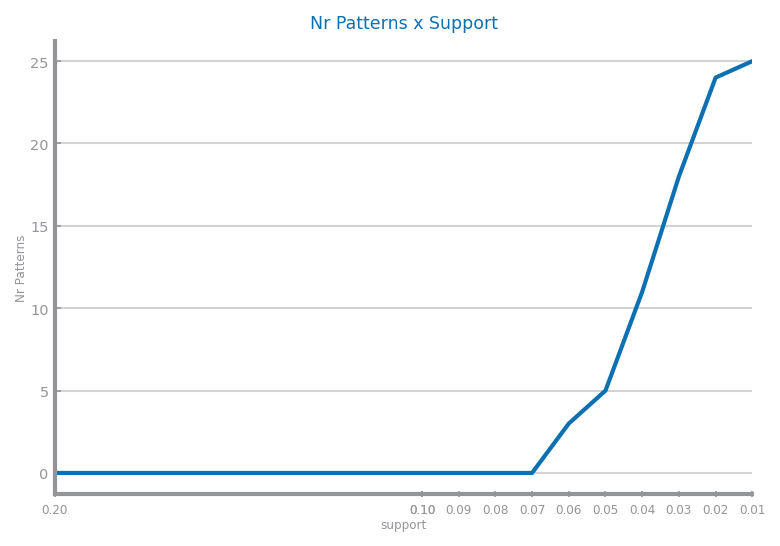

In [60]:
MIN_SUP: float = 0.001
var_min_sup =[0.2, 0.1] + [i*MIN_SUP for i  in range(100, 0, -10)]

patterns: DataFrame = apriori(data, min_support=MIN_SUP, use_colnames=True, verbose=True)
print(len(patterns),'patterns')
nr_patterns = []
for sup in var_min_sup:
    pat = patterns[patterns['support'] >= sup]
    nr_patterns.append(len(pat))

figure(figsize=(6, 4))
plot_line(var_min_sup, nr_patterns, title='Nr Patterns x Support', xlabel='support', ylabel='Nr Patterns')
savefig(f'images/{file_tag}/{file_tag}_{data_treatment}_patterns_support.png')
show()

In [61]:
MIN_CONF: float = 0.1
rules = association_rules(patterns, metric='confidence', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 304 rules


In [62]:
def plot_top_rules(rules: DataFrame, metric: str, per_metric: str, file_tag: str, data_treatment: str) -> None:
    _, ax = subplots(figsize=(6, 3))
    ax.grid(False)
    ax.set_axis_off()
    ax.set_title(f'TOP 10 per Min {per_metric} - {metric}', fontweight="bold")
    text = ''
    cols = ['antecedents', 'consequents']
    rules[cols] = rules[cols].applymap(lambda x: tuple(x))
    for i in range(len(rules)):
        rule = rules.iloc[i]
        text += f"{rule['antecedents']} ==> {rule['consequents']}"
        text += f"(s: {rule['support']:.2f}, c: {rule['confidence']:.2f}, lift: {rule['lift']:.2f})\n"
    ax.text(0, 0, text)
    savefig(f'images/{file_tag}/{file_tag}_{data_treatment}_top_{metric}_{per_metric}.png')
    show()

def analyse_per_metric(rules: DataFrame, metric: str, metric_values: list, file_tag: str, data_treatment: str) -> list:
    print(f'Analyse per {metric}...')
    conf = {'avg': [], 'top25%': [], 'top10': []}
    lift = {'avg': [], 'top25%': [], 'top10': []}
    top_conf = []
    top_lift = []
    nr_rules = []
    for m in metric_values:
        rs = rules[rules[metric] >= m]
        nr_rules.append(len(rs))
        conf['avg'].append(rs['confidence'].mean(axis=0))
        lift['avg'].append(rs['lift'].mean(axis=0))

        top_conf = rs.nlargest(int(0.25*len(rs)), 'confidence')
        conf['top25%'].append(top_conf['confidence'].mean(axis=0))
        top_lift = rs.nlargest(int(0.25*len(rs)), 'lift')
        lift['top25%'].append(top_lift['lift'].mean(axis=0))

        top_conf = rs.nlargest(10, 'confidence')
        conf['top10'].append(top_conf['confidence'].mean(axis=0))
        top_lift = rs.nlargest(10, 'lift')
        lift['top10'].append(top_lift['lift'].mean(axis=0))

    _, axs = subplots(1, 2, figsize=(10, 5), squeeze=False)
    multiple_line_chart(metric_values, conf, ax=axs[0, 0], title=f'Avg Confidence x {metric}',
                           xlabel=metric, ylabel='Avg confidence')
    multiple_line_chart(metric_values, lift, ax=axs[0, 1], title=f'Avg Lift x {metric}',
                           xlabel=metric, ylabel='Avg lift')
    savefig(f'images/{file_tag}/{file_tag}_{data_treatment}_{metric}_avg_lift_avg_confidence.png')
    show()

    plot_top_rules(top_conf, 'confidence', metric, file_tag, data_treatment)
    plot_top_rules(top_lift, 'lift', metric, file_tag, data_treatment)

    return nr_rules

Analyse per support...


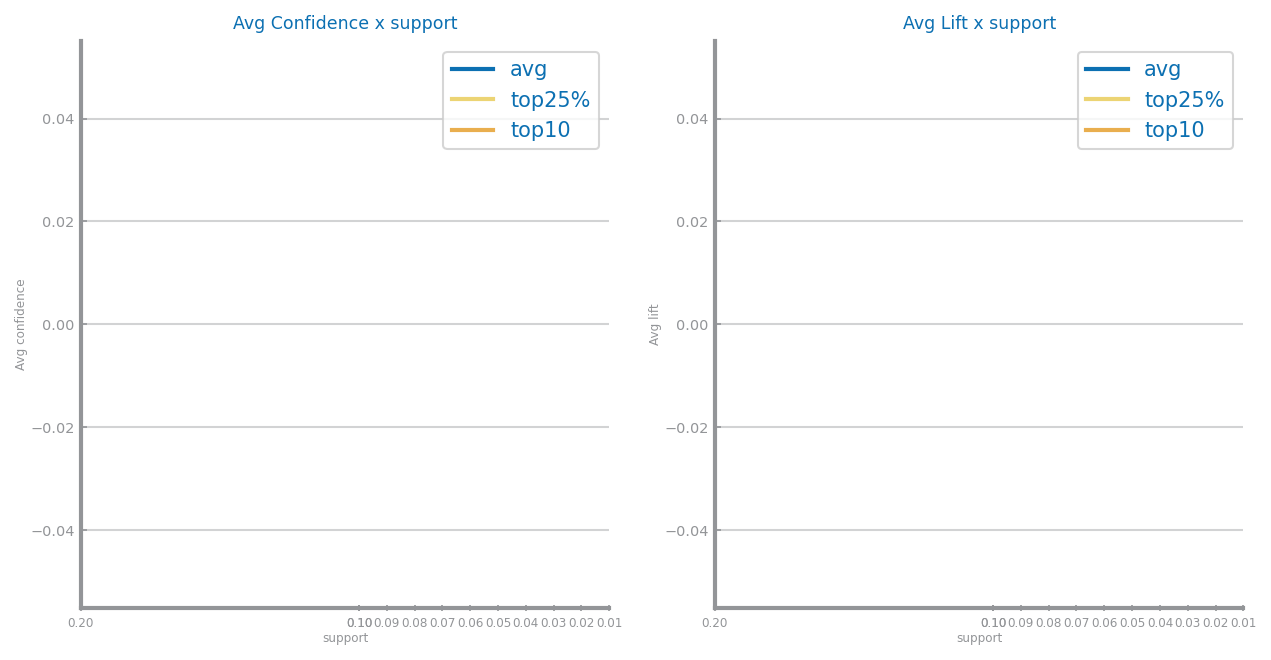

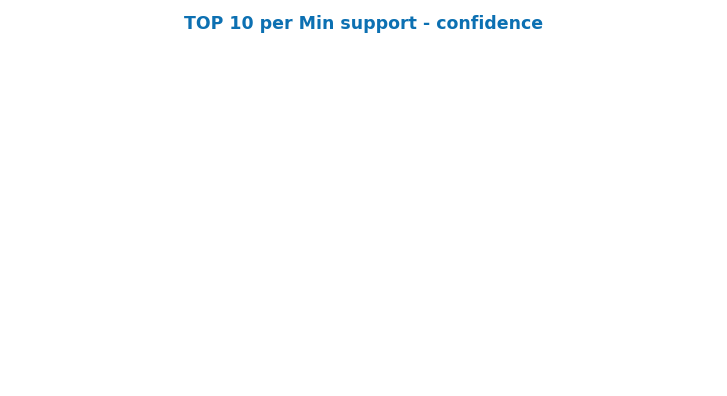

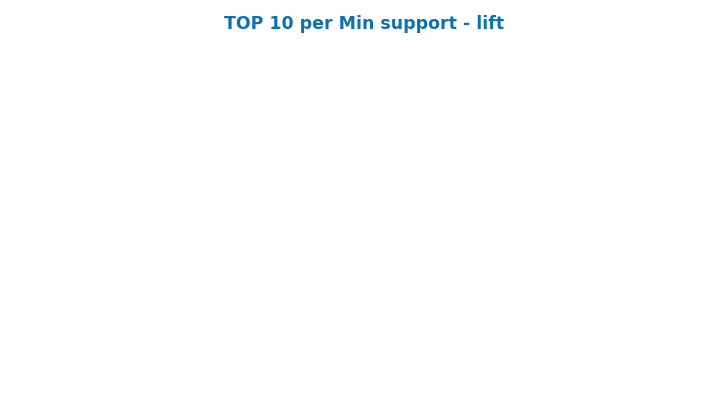

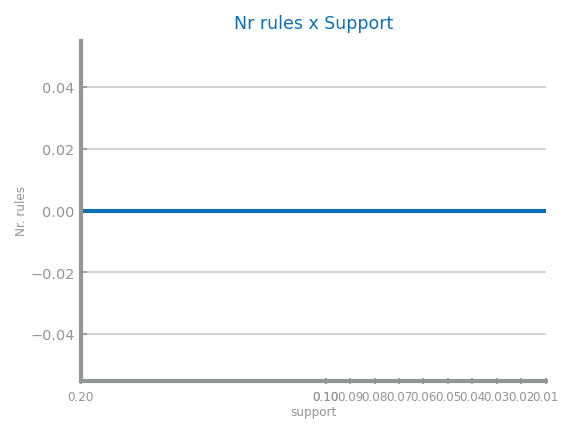

In [63]:
nr_rules_sp = analyse_per_metric(rules, 'support', var_min_sup, file_tag, data_treatment)
plot_line(var_min_sup, nr_rules_sp, title='Nr rules x Support', xlabel='support', ylabel='Nr. rules', percentage=False)
savefig(f'images/{file_tag}/{file_tag}_{data_treatment}_rules_support.png')

Analyse per confidence...


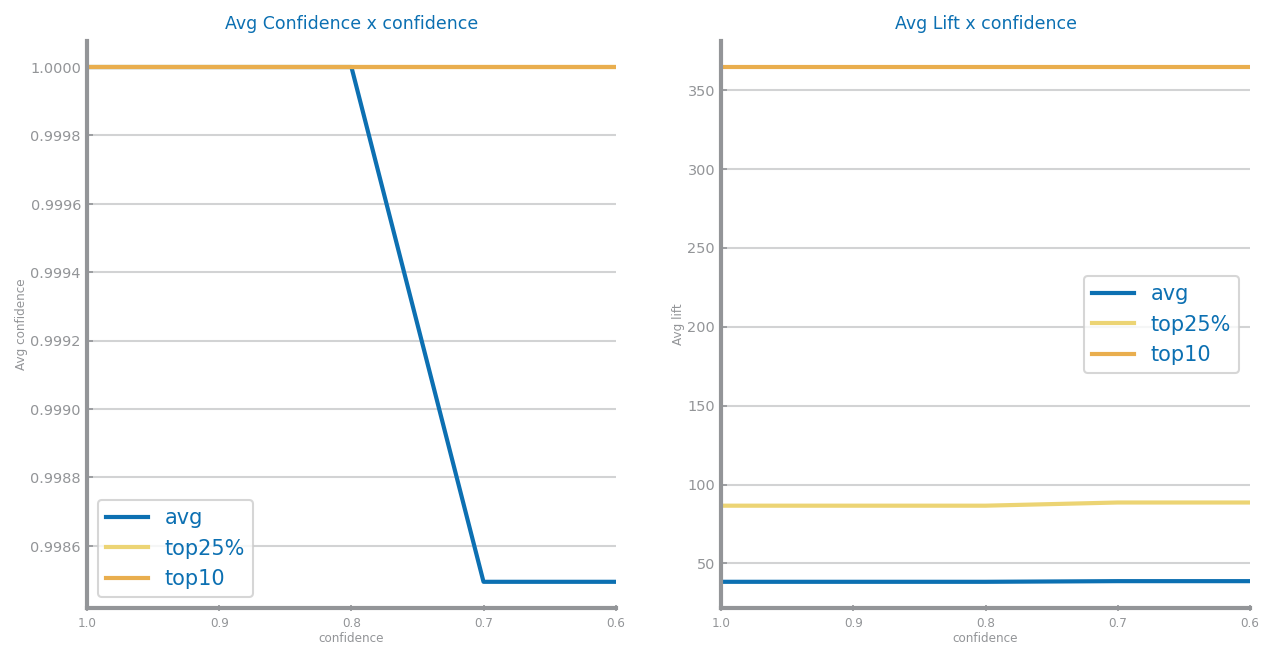

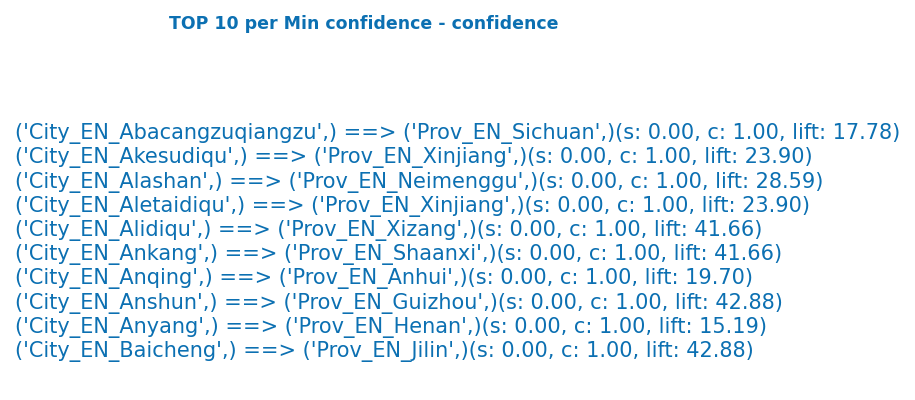

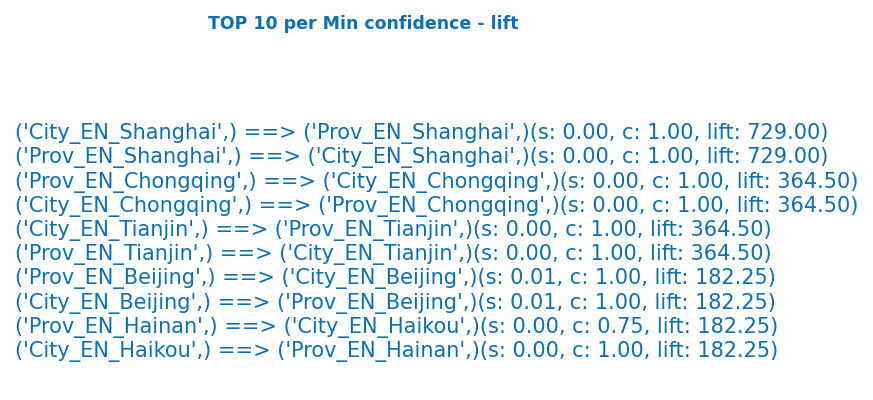

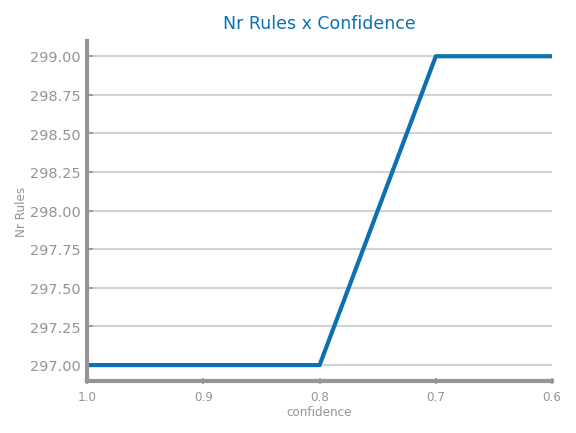

In [64]:
var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
nr_rules_cf = analyse_per_metric(rules, 'confidence', var_min_conf, file_tag, data_treatment)
plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x Confidence', xlabel='confidence', ylabel='Nr Rules', percentage=False)
savefig(f'images/{file_tag}/{file_tag}_{data_treatment}_rules_confidence.png')